In [1]:
import uproot
import hist
import os
import numpy as np
import argparse
from array import array
import awkward as ak
from uncertainties import ufloat, unumpy
import matplotlib.pyplot as plt
import mplhep
from itertools import chain
from timeit import timeit
from ROOT import TFile, TH1D, TH2D

Welcome to JupyROOT 6.22/06


In [2]:
import dask
import dask.dataframe as dd
from dask.distributed import Client
from dask.distributed import get_client
from dask.distributed import wait


In [2]:
def compute_response_matrix(var_name, gen_axes, reco_axes, gen_step8_data, step8_data, gen_step0_data, gen_step8_weights, step8_weights, gen_step0_weights):
    
    axes = gen_axes + reco_axes
        
    response_matrix = hist.Hist(*axes, storage=hist.storage.Weight())
    
    # fill the reconstructed events
    response_matrix.fill(*gen_step8_data, *step8_data, weight=step8_weights)

    # fill the generator level events in the reconstruction underflow bin
    # this is back at step0 so that we can unfold back to full phase space
    response_matrix.fill(*gen_step0_data, *([np.ones(len(gen_step0_data[0])) * (reco_axes[0][0][0] - 1) for i in range(len(gen_step0_data))]), weight=gen_step0_weights)

    # next create a separate response matrix to fill the reco weights
    # this is because we need to subtract the entries AND variances and can't
    # do that with a "simple" negative weight (this would only subtract entries,
    # variances are sum of weights squared)
    _response_matrix = hist.Hist(*axes, storage=hist.storage.Weight())

    # fill this new matrix
    _response_matrix.fill(*gen_step8_data, *([np.ones(len(gen_step8_data[0])) * (reco_axes[0][0][0] - 1) for i in range(len(gen_step8_data))]), weight=step8_weights)

    # set values and variances equal to the difference between response_matrix
    # and _response_matrix to account for these events that aren't reconstructed
    response_matrix[...] = np.concatenate(
        ((response_matrix.values(flow=True) - _response_matrix.values(flow=True))[..., None],
         (response_matrix.variances(flow=True) - _response_matrix.variances(flow=True))[..., None]),
        axis=len(axes)
    )

    return response_matrix

In [3]:
era        = '2017'
channel    = 'emu'
systematic = 'Nominal'

filename = 'emu_ttbarsignalplustau_fromDilepton_2017UL_0.root'
dir_name = '/mnt/hadoop/store/group/local/cmstop/jthiema/2017/spinCorrInput_2017UL_DeepJet_August2022'

#filename  = 'emu_ttbarsignalplustau.root'
#dir_name  = '/mnt/hadoop/store/group/local/cmstop/jthiema/2016_old/spinCorrInputUnsymmetrized_2016'

In [4]:
# open the minitree
step0tree = uproot.open(dir_name+'/'+systematic+'/'+channel+'/'+filename+':ttBar_treeVariables_step0')
step8tree = uproot.open(dir_name+'/'+systematic+'/'+channel+'/'+filename+':ttBar_treeVariables_step8')

In [5]:
tree_vars = [
    "ll_cHel","ll_cLab","llbar_delta_phi","llbar_delta_eta",
    "b1k","b2k","b1r","b2r","b1n","b2n","b1j","b2j","b1q","b2q",
    "c_kk","c_rr","c_nn","c_kj","c_rq","c_rq",   
    "c_rk","c_kr","c_nr","c_rn","c_nk","c_kn",
#    "c_rj","c_jr",
    
    "gen_ll_cHel","gen_ll_cLab","gen_llbar_delta_phi","gen_llbar_delta_eta",
    "gen_b1k","gen_b2k","gen_b1r","gen_b2r","gen_b1n","gen_b2n","gen_b1j","gen_b2j","gen_b1q","gen_b2q",
    "gen_c_kk","gen_c_rr","gen_c_nn","gen_c_kj","gen_c_rq","gen_c_rq",   
    "gen_c_rk","gen_c_kr","gen_c_nr","gen_c_rn","gen_c_nk","gen_c_kn",
#    "gen_c_rj","gen_c_jr",
    
    "eventWeight", "trueLevelWeight",
    "gen_l_pt", "gen_lbar_pt", "gen_l_eta", "gen_lbar_eta", 
    "gen_b_pt", "gen_bbar_pt", "gen_b_eta", "gen_bbar_eta",
    "gen_l_pdgid", "gen_lbar_pdgid",
    ]

In [6]:
var     = "ll_cHel"
genvar  = "gen_" + var

binning         = [24, -1.0, 1.0]
residualbinning = [48, -2.0, 2.0]

vars_dict = {
#    key variable : [ left bin edge [0], right bin edge [1], number of gen bins [2], number of reco bins [3], 
#    left residual edge [4], right residual edge [5], number of residual bins [6], ]
    "ll_cHel" : [-1.0, 1.0, 24, 48, -2.0, 2.0, 48],
}

In [8]:
step0_raw = ak.Array(
            ak.zip( dict( (var, step0tree[var].array()) for var in tree_vars ) )
            )

step0_mask = (step0_raw.gen_l_pdgid * step0_raw.gen_lbar_pdgid == -11*13)
step0      = step0_raw[step0_mask]
print(len(step0))

step8 = ak.Array(
        ak.zip( dict( (var, step8tree[var].array()) for var in tree_vars ) )
        )

1205537


In [17]:
step0_raw.gen_l_pdgid

<Array [13, 13, 11, 13, 11, ... 13, 11, 11, 11] type='2411411 * float32'>

In [18]:
step0_raw.gen_lbar_pdgid

<Array [-13, -13, -13, -11, ... -13, -13, -13] type='2411411 * float32'>

In [19]:
-11*13

-143

In [10]:
gen_axes      = [hist.axis.Regular(vars_dict["ll_cHel"][2], vars_dict["ll_cHel"][0], vars_dict["ll_cHel"][1], name="gen_"+"ll_cHel", label="gen_"+"ll_cHel", underflow=True, overflow=True),]
reco_axes     = [hist.axis.Regular(vars_dict["ll_cHel"][3], vars_dict["ll_cHel"][0], vars_dict["ll_cHel"][1], name="reco_"+"ll_cHel", label="reco_"+"ll_cHel", underflow=True, overflow=True)]
residual_axes = [hist.axis.Regular(vars_dict["ll_cHel"][6], vars_dict["ll_cHel"][4], vars_dict["ll_cHel"][5], name="residual_"+"ll_cHel", label="residual_"+"ll_cHel", underflow=True, overflow=True)]
visgen_axes   = [hist.axis.Regular(vars_dict["ll_cHel"][2], vars_dict["ll_cHel"][0], vars_dict["ll_cHel"][1], name="visgen_"+"ll_cHel", label="visgen_"+"ll_cHel", underflow=True, overflow=True),]

print(reco_axes[0][0][0])

-1.0


WeightedSumView(
      [[(0.00000000e+00, 0.00000000e+00),
        (0.00000000e+00, 0.00000000e+00),
        (0.00000000e+00, 0.00000000e+00), ...,
        (0.00000000e+00, 0.00000000e+00),
        (0.00000000e+00, 0.00000000e+00),
        (0.00000000e+00, 0.00000000e+00)],
       [(2.24803427e+06, 1.69221855e+08),
        (1.02678596e+05, 6.86229227e+06),
        (8.11674186e+04, 5.43177074e+06), ...,
        (7.01153526e+02, 5.17372043e+04),
        (7.26250767e+02, 4.80795274e+04),
        (0.00000000e+00, 0.00000000e+00)],
       [(2.30340737e+06, 1.73236008e+08),
        (3.46655599e+04, 2.35997505e+06),
        (4.23070234e+04, 2.87047627e+06), ...,
        (6.39272572e+02, 4.59916936e+04),
        (5.03745567e+02, 3.69732335e+04),
        (0.00000000e+00, 0.00000000e+00)],
       ...,
       [(3.52858486e+06, 2.64645019e+08),
        (5.46937759e+02, 3.79074198e+04),
        (4.10873981e+02, 2.47498041e+04), ...,
        (8.16242939e+04, 5.45494887e+06),
        (8.77679137e+04,

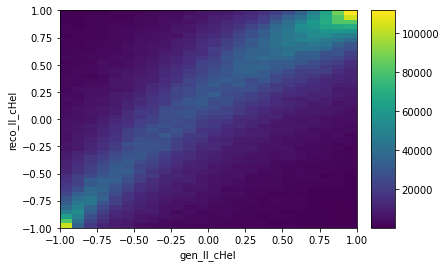

In [11]:
resmat = compute_response_matrix('ll_cHel', gen_axes, reco_axes, [step8[genvar]], [step8[var]], [step0[genvar]], [step8['trueLevelWeight']], [step8['eventWeight']], [step0['trueLevelWeight']])
resmat.plot()
resmat.view(flow=True)

In [12]:
resmat

Hist(
  Regular(24, -1, 1, name='gen_ll_cHel', label='gen_ll_cHel'),
  Regular(48, -1, 1, name='reco_ll_cHel', label='reco_ll_cHel'),
  storage=Weight()) # Sum: WeightedSum(value=1.65942e+07, variance=1.11928e+09) (WeightedSum(value=8.6924e+07, variance=6.39951e+09) with flow)

In [13]:
h_reco = hist.Hist(
    *[reco_axes][0],
    storage=hist.storage.Weight()
)
h_reco.fill(*[step8[var]], weight=[step8['eventWeight']])

Hist(Regular(48, -1, 1, name='reco_ll_cHel', label='reco_ll_cHel'), storage=Weight()) # Sum: WeightedSum(value=1.65942e+07, variance=1.11928e+09)

In [14]:
h_gen = hist.Hist(
    *[gen_axes][0],
    storage=hist.storage.Weight()
)
h_gen.fill(*[step0[genvar]], weight=[step0['trueLevelWeight']])
h_gen.view(flow=True)

WeightedSumView(
      [(      0.        , 0.00000000e+00),
       (2875789.95600128, 2.11596796e+08),
       (2921423.48856354, 2.15229586e+08),
       (2993405.80722008, 2.20361877e+08),
       (3077229.11815987, 2.26467169e+08),
       (3123933.11510086, 2.29859050e+08),
       (3186452.46414185, 2.34543789e+08),
       (3246855.62270318, 2.39401704e+08),
       (3314899.07508469, 2.44290056e+08),
       (3371628.57585106, 2.48147067e+08),
       (3446994.43769836, 2.54092976e+08),
       (3522464.82840729, 2.59304107e+08),
       (3612759.07202874, 2.66093416e+08),
       (3652045.15499878, 2.69118008e+08),
       (3698978.08378144, 2.72256123e+08),
       (3783550.20925903, 2.78439131e+08),
       (3855446.68992577, 2.83716818e+08),
       (3930724.8501091 , 2.89475849e+08),
       (3957111.41168594, 2.91310260e+08),
       (4081643.66692696, 3.00346248e+08),
       (4099304.56878662, 3.01754415e+08),
       (4228026.29920578, 3.11110858e+08),
       (4250553.98639566, 3.12610403e

In [15]:
h_resolutionbins = hist.Hist(
    *[residual_axes][0],
    *[gen_axes][0],
    storage=hist.storage.Weight()
)
h_resolutionbins.fill(*([step8[var] - step8[genvar]]), *[step8[genvar]], weight=[step8['eventWeight']])

Hist(
  Regular(48, -2, 2, name='residual_ll_cHel', label='residual_ll_cHel'),
  Regular(24, -1, 1, name='gen_ll_cHel', label='gen_ll_cHel'),
  storage=Weight()) # Sum: WeightedSum(value=1.65942e+07, variance=1.11928e+09)

In [16]:
visgen_mask = (step0.gen_l_pt > 20.0) & (step0.gen_lbar_pt > 20.0) & (abs(step0.gen_l_eta) < 2.4) & (abs(step0.gen_lbar_eta) < 2.4) & (step0.gen_b_pt > 30) & (step0.gen_bbar_pt > 30) & (abs(step0.gen_b_eta) < 2.4) & (abs(step0.gen_bbar_eta) < 2.4)
visgen_step0 = step0[visgen_mask]
h_visgen = hist.Hist(
    *[visgen_axes][0],
    storage=hist.storage.Weight()
)
h_visgen.fill(*[visgen_step0[genvar]], weight=[visgen_step0['trueLevelWeight']])
h_visgen.view(flow=True)

WeightedSumView(
      [(      0.        , 0.00000000e+00),
       (1300441.25298309, 9.54831936e+07),
       (1304794.64103699, 9.60107815e+07),
       (1314941.82392883, 9.67515302e+07),
       (1318691.89221573, 9.69495282e+07),
       (1333702.37337494, 9.78529189e+07),
       (1366966.15164185, 1.00493644e+08),
       (1374157.14279556, 1.01267047e+08),
       (1407669.07536316, 1.03527916e+08),
       (1435949.5371357 , 1.05408170e+08),
       (1443054.20204163, 1.06109773e+08),
       (1479866.15776443, 1.08761637e+08),
       (1512678.22012673, 1.11154661e+08),
       (1539835.87940598, 1.13098344e+08),
       (1574752.11375427, 1.15676072e+08),
       (1616436.22521591, 1.18554581e+08),
       (1658962.39094124, 1.22037012e+08),
       (1698819.42272568, 1.24735189e+08),
       (1711606.90140533, 1.25727189e+08),
       (1764802.46419487, 1.29690108e+08),
       (1779953.59680939, 1.30807935e+08),
       (1845962.68518829, 1.35557927e+08),
       (1877206.30863533, 1.37743619e

In [16]:
filename   = 'emu_ttbarsignalplustau.root'
dir_name   = '/mnt/hadoop/store/group/local/cmstop/jthiema/2016_old/spinCorrInputUnsymmetrized_2016'
systematic = 'Nominal'
channel    = 'emu'

In [17]:
step0 = ak.Array(
    ak.zip( dict( (var, step0tree[var].array()) for var in tree_vars ) )
)

step8 = ak.Array(
    ak.zip( dict( (var, step8tree[var].array()) for var in tree_vars ) )
)

In [18]:
tree_vars = [
    "ll_cHel",    "gen_ll_cHel",
        "gen_l_pt", "gen_lbar_pt", "gen_l_eta", "gen_lbar_eta", 
    "gen_b_pt", "gen_bbar_pt", "gen_b_eta", "gen_bbar_eta",
        "eventWeight", "trueLevelWeight",
    ]

In [19]:
# open the minitree
step0tree = uproot.open(dir_name+'/'+systematic+'/'+channel+'/'+filename+':ttBar_treeVariables_step0')
step8tree = uproot.open(dir_name+'/'+systematic+'/'+channel+'/'+filename+':ttBar_treeVariables_step8')

In [20]:
step0 = ak.Array(
    ak.zip( dict( (var, step0tree[var].array()) for var in tree_vars ) )
)

step8 = ak.Array(
    ak.zip( dict( (var, step8tree[var].array()) for var in tree_vars ) )
)

In [21]:
gen_axes = [hist.axis.Regular(vars_dict["ll_cHel"][2], vars_dict["ll_cHel"][0], vars_dict["ll_cHel"][1], name="gen_"+"ll_cHel", label="gen_"+"ll_cHel", underflow=True, overflow=True),]
reco_axes = [hist.axis.Regular(vars_dict["ll_cHel"][3], vars_dict["ll_cHel"][0], vars_dict["ll_cHel"][1], name="reco_"+"ll_cHel", label="reco_"+"ll_cHel", underflow=True, overflow=True)]

WeightedSumView(
      [[(0.00000000e+00, 0.00000000e+00),
        (0.00000000e+00, 0.00000000e+00),
        (0.00000000e+00, 0.00000000e+00), ...,
        (0.00000000e+00, 0.00000000e+00),
        (0.00000000e+00, 0.00000000e+00),
        (0.00000000e+00, 0.00000000e+00)],
       [(9.56893597e+04, 1.04590285e+05),
        (3.76765969e+03, 3.70355573e+03),
        (3.14329008e+03, 3.09384958e+03), ...,
        (3.60934575e+01, 3.65396712e+01),
        (3.44752380e+01, 3.45428007e+01),
        (0.00000000e+00, 0.00000000e+00)],
       [(9.90985848e+04, 1.08216582e+05),
        (1.33117397e+03, 1.31285133e+03),
        (1.71685024e+03, 1.67808205e+03), ...,
        (3.01685116e+01, 2.86340150e+01),
        (3.24733991e+01, 3.31278372e+01),
        (0.00000000e+00, 0.00000000e+00)],
       ...,
       [(1.49899942e+05, 1.63525670e+05),
        (2.07352689e+01, 2.04159812e+01),
        (1.39100780e+01, 1.36434787e+01), ...,
        (3.10569015e+03, 3.03549244e+03),
        (2.99829072e+03,

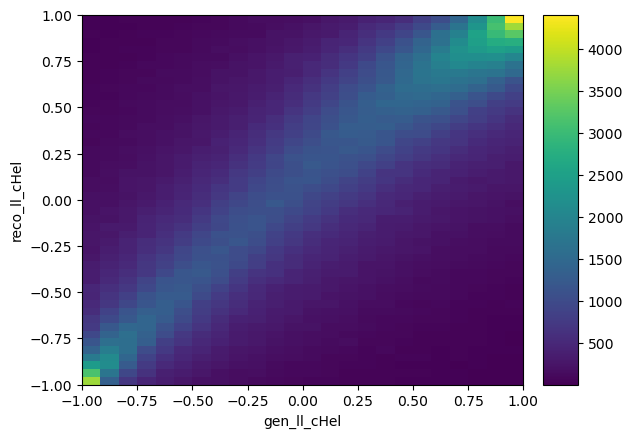

In [22]:
resmat = compute_response_matrix('ll_cHel', gen_axes, reco_axes, [step8[genvar]], [step8[var]], [step0[genvar]], [step8['trueLevelWeight']], [step8['eventWeight']], [step0['trueLevelWeight']])
resmat.plot()
resmat.view(flow=True)

In [23]:
resmat

Hist(
  Regular(24, -1, 1, name='gen_ll_cHel'),
  Regular(48, -1, 1, name='reco_ll_cHel'),
  storage=Weight()) # Sum: WeightedSum(value=646532, variance=635743) (WeightedSum(value=3.63727e+06, variance=3.89957e+06) with flow)

In [24]:
visgen_mask = (step0.gen_l_pt > 20.0) & (step0.gen_lbar_pt > 20.0) & (abs(step0.gen_l_eta) < 2.4) & (abs(step0.gen_lbar_eta) < 2.4) & (step0.gen_b_pt > 30) & (step0.gen_bbar_pt > 30) & (abs(step0.gen_b_eta) < 2.4) & (abs(step0.gen_bbar_eta) < 2.4)
visgen_step0 = step0[visgen_mask]
h_visgen = hist.Hist(
    *[visgen_axes][0],
    storage=hist.storage.Weight()
)
h_visgen.fill(*[visgen_step0[genvar]], weight=[visgen_step0['trueLevelWeight']])

Hist(Regular(24, -1, 1, name='visgen_ll_cHel'), storage=Weight()) # Sum: WeightedSum(value=1.55799e+06, variance=1.67031e+06)

In [25]:
h_visgen.view(flow=True)

WeightedSumView(
      [(    0.        ,     0.        ), (53317.37708077, 57192.60060069),
       (53826.13096238, 57708.21925326), (53420.7232437 , 57276.90273364),
       (54667.69975093, 58601.61745743), (55005.65689983, 58953.36481312),
       (56310.38705718, 60362.27771014), (57380.076651  , 61529.33553255),
       (58304.99871864, 62543.82864853), (59337.21636078, 63596.19847958),
       (60794.07352884, 65181.15189396), (61711.29051105, 66148.30562763),
       (63198.29603577, 67784.93197929), (64222.68570498, 68884.46636426),
       (65661.6308858 , 70344.73769017), (67437.63808811, 72300.07337249),
       (69292.70524119, 74268.91992145), (69593.37422777, 74574.64173477),
       (71428.99172976, 76602.27374398), (73008.59063763, 78291.55361222),
       (74700.26054673, 80113.49079995), (76730.26582219, 82274.23027568),
       (78025.2720917 , 83611.51279046), (79630.14604298, 85329.43130092),
       (80981.9157162 , 86831.40092427), (    0.        ,     0.        )],
      d

In [26]:
print(step0['gen_l_pt'])

[69.9, 61.8, 54.1, 29.3, 40.2, 18.5, 119, ... 21.1, 49.2, 30.4, 13.6, 57.3, 40.8]


In [34]:
print(visgen_step0['gen_l_pt'])
len(visgen_step0['gen_l_pt'])

[69.9, 54.1, 29.3, 104, 33, 88.2, 28.5, ... 73.1, 68.3, 102, 20.3, 58.9, 57.3, 40.8]


1549454

In [28]:
print(step0['gen_lbar_pt'])

[27, 42.1, 33.3, 91.1, 19.1, 19.3, 92.9, ... 38.1, 63.1, 43.6, 25.1, 38.4, 89.3, 49]


In [29]:
print(step0['gen_l_eta'])

[0.783, 1.4, -0.504, 1.3, -1.79, -2.53, ... -2.07, -0.656, 0.82, 0.667, 0.3, -0.876]


In [30]:
print(step0['gen_lbar_eta'])

[0.0831, -0.0245, 0.295, 1.64, -0.813, -1.64, ... -1.12, 3.81, -0.0254, -1.56, 0.615]


In [31]:
print(visgen_step0['gen_b_pt'])

[72.7, 58.6, 49.9, 128, 71.8, 75.1, 96.7, ... 44.3, 66.6, 32.9, 54.5, 45.1, 88.8]


In [32]:
print(step0['gen_bbar_pt'])

[82.9, 25.1, 82, 31.8, 76, 84.8, 80.6, ... 64.9, 126, 25.5, 45.6, 66.9, 43.8, 76.5]


In [35]:
print(visgen_step0['gen_b_eta'])

[2.07, 0.0959, 0.255, -0.956, 1.11, 0.156, ... -1.31, 2.1, -0.945, -0.0657, 0.397]


In [36]:
print(step0['gen_bbar_eta'])

[0.778, 0.35, -0.568, 1.36, -2.37, -1.04, ... -2.04, 0.301, 0.362, 1.38, -1.57]
